In [3]:
import numpy as np
import os
from PIL import Image, ImageDraw
import shutil
import scipy.io as sio
import pydicom
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
import gzip
import nibabel as nib

In [20]:
def check_data():
    label_dir = "K:\dataset\\NPC\CET1_label"
    mv_dir = "K:\dataset\\NPC\CET1_label_removed"
    dicom_dir = "K:\dataset\\NPC\Image_dicom"
    files = os.listdir(label_dir)
    
    # move label like xxxx_Label_1_2
    for file in files:
        if file.split('_')[-2] == "Label":
            continue
        else:
            shutil.move(os.path.join(label_dir, file), os.path.join(mv_dir, file))
    
    print("move duplicated file finished")
    
    # check completion for samples
    files = os.listdir(label_dir)
    dictionary = {}
    for file in files:
        name = file.split('_')[-4]
        if name not in dictionary:
            dictionary[name] = 0.5
        else:
            dictionary[name] = 1
    for item in dictionary:
        if dictionary[item] != 1:
            print(item)
    print("check completion finished")
    
    # check ID length
    files = os.listdir(label_dir)
    for file in files:
        name = file.split('_')[-4]
        if len(name) != 8:
            print(file)
            print(file.split('_'))
    print("ID length check finished")
    
    # check correspondence with dicom
    label_ids = np.array(list(dictionary.keys()))
    dicom_ids = np.array(os.listdir(dicom_dir))
    print(len(label_ids), len(dicom_ids))
    inter = np.intersect1d(label_ids, dicom_ids)
    diff = np.setdiff1d(label_ids, dicom_ids)
    # print(len(inter))
    # print(diff)
    return inter

inter = check_data()

move duplicated file finished
check completion finished
ID length check finished
785 810
781
['10103282' '10110010' '10119084' '10122462']


In [22]:
def chose_data():
    
    label_dir = "K:\dataset\\NPC\CET1_label"
    mv_dir = "K:\dataset\\NPC\CET1_label_unpaired"
    dicom_dir = "K:\dataset\\NPC\Image_dicom"
    dicom_dir_mv = "K:\dataset\\NPC\Image_dicom_unpaired"
    
    files = os.listdir(label_dir)
    dirs = os.listdir(dicom_dir)
    
    # move label like xxxx_Label_1_2
    for file in files:
        if file.split('_')[-4] in inter:
            continue
        else:
            shutil.move(os.path.join(label_dir, file), os.path.join(mv_dir, file))
    
    for dir in dirs:
        if dir in inter:
            continue
        else:
            shutil.move(os.path.join(dicom_dir, dir), os.path.join(dicom_dir_mv, dir))
    
chose_data()

In [24]:
def divide_label():
    
    input = "K:\dataset\\NPC\label_tumor"
    output = "K:\dataset\\NPC\label_lymphaden"
    
    files = os.listdir(input)
    
    for file in files:
        if str(file.split('_')[-1]) == "2.mat":
            shutil.move(os.path.join(input, file), os.path.join(output, file))

divide_label()


In [34]:
def format_label():
    

    tumor_src = "K:\dataset\\NPC\label_tumor"
    lym_src = "K:\dataset\\NPC\label_lymphaden"
    tumor_target = "K:\dataset\\NPC\label_tumor_merged"
    lym_target = "K:\dataset\\NPC\label_lymphaden_merged"
    
    files = os.listdir(tumor_src)
    for file in files:
        mat = sio.loadmat(os.path.join(tumor_src, file))['seg1'].astype(np.uint8)
        np.save(os.path.join(tumor_target, file.split('_')[-4]), mat)
    
    files = os.listdir(lym_src)
    for file in files:
        mat = sio.loadmat(os.path.join(lym_src, file))['seg2'].astype(np.uint8)
        np.save(os.path.join(lym_target, file.split('_')[-4]), mat)

format_label()

In [48]:
def extract_dicom():
    src = "K:\dataset\\NPC\Image_dicom"
    dst = "K:\dataset\\NPC\image_divide"
    ids = os.listdir(src)
    num = 0
    for id in ids:
        series = os.listdir(os.path.join(src, id))
        for series_item in series:
            keywords = series_item.split('_')
            if "OAXI" in keywords or "OAX" in keywords or "OAx" in keywords or "tra" in keywords:
                shutil.copytree(os.path.join(src, id, series_item), os.path.join(dst, id, series_item))
    # print(num)
        
extract_dicom()


In [19]:
def check_num():
    src = "J:\Dataset\\new\\dicom"
    ids = os.listdir(src)
    
    for id in sorted(ids):
        num = os.listdir(os.path.join(src, id))
        if len(num) != 3:
            print(id, num)
check_num()

10139484 ['T1C', 'T2']


In [3]:
def fuse_label():
    
    tumor_dir = "K:\dataset\\NPC\label_tumor"
    lympha_dir = "K:\dataset\\NPC\label_lympha"
    tumor_nonzero = "K:\dataset\\NPC\\NPC_V2\label_tumor_accord"
    lympha_nonzero = "K:\dataset\\NPC\\NPC_V2\label_lympha_nonzero"
    output_dir = "K:\dataset\\NPC\label_fuse"
    output_dir_nonzero = "K:\dataset\\NPC\\NPC_V2\label_fuse_nonzero"
    
    tumor_files = os.listdir(tumor_dir)
    lymph_files = os.listdir(lympha_dir)
    fuse_files = os.listdir(output_dir)
    
    # print((np.unique(tumor_files) == np.unique(lymph_files)).all(), 
    #       np.unique(tumor_files).shape, np.unique(lymph_files).shape)
    # 
    flag = True
    # 
    # for file in tumor_files:
    #     img = np.load(os.path.join(tumor_dir, file))
    #     if (np.unique(img) == np.array([0, 1])).all():
    #         continue
    #     else:
    #         flag = False
    # 
    # print(flag)
    # 
    # for file in lymph_files:
    #     img = np.load(os.path.join(lympha_dir, file))
    #     if (np.unique(img) == np.array([0, 1])).all() or (np.unique(img) == np.array([0])).all():
    #         continue
    #     else:
    #         flag = False
    # 
    # print(flag)
    num = 0
    for file in fuse_files:
        img = np.load(os.path.join(output_dir, file))
        print(np.unique(img))
        # if (np.unique(img) == np.array([0, 1, 2])).all() or (np.unique(img) == np.array([0, 1])).all():
        if len(np.unique(img)) == 3:
            continue
        elif len(np.unique(img)) == 2:
            num += 1
        else:
            flag = False

    print(flag, num)
    
    # flag = True
    # for file in tumor_files:
    # 
    #     tumor = np.load(os.path.join(tumor_dir, file))
    #     lymph = np.load(os.path.join(lympha_dir, file))
    #     # if not (np.array(tumor.shape) == np.array(lymph.shape)).all():
    #     #     flag = False
    #     #     break
    #     fuse = np.zeros(shape=tumor.shape)
    #     fuse[tumor == 1] = 1
    #     fuse[lymph == 1] = 2
    #     np.save(os.path.join(output_dir, file), fuse.astype(np.uint8))
    #     print(file)
        
    
    
label = fuse_label()

[0 1 2]
[0 1 2]
[0 1]
[0 1]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1]
[0 1 2]
[0 1 2]
[0 1]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1]
[0 1 2]
[0 1]
[0 1 2]
[0 1]
[0 1]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1]
[0 1 2]
[0 1]
[0 1 2]
[0 1]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1]
[0 1 2]
[0 1 2]
[0 1]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1]
[0 1]
[0 1]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1]
[0 1]
[0 1 2]
[0 1]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1]
[0 1 2]
[0 1]
[0 1 2]
[0 1]
[0 1]
[0 1 2]
[0 1 2]
[0 1]
[0 1 2]
[0 1 2]
[0 1]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1]
[0 1 2]
[0 1 2]
[0 1]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1]
[0 1 2]
[0 1]
[0 1]
[0 1 2]
[0 1 2]
[0 1]
[0 1]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1]
[0 1 2]
[0 1 2]
[0

In [19]:
def rename():
    
    src = "K:\dataset\\NPC\image_divide"
    label = "K:\dataset\\NPC\label_fuse"
    ids = os.listdir(src)
    types = []
    for id in ids:
        
        series = os.listdir(os.path.join(src, id))
        
        if "T2" not in series or "T1C" not in series or "T1" not in series or len(series) != 3:
            print(id)
        
        num0 = len(os.listdir(os.path.join(src, id, series[0])))
        num1 = len(os.listdir(os.path.join(src, id, series[1])))
        num2 = len(os.listdir(os.path.join(src, id, series[2])))
        
        if not (num0 == num1 == num2):
            print(id)
        
        # if len(series) != 3:
        #     print(id)
        
        # for sery in series:
            # FOR T2
            # if "T2" in sery.split('_') or "t2" in sery.split('_'):
            #     shutil.move(os.path.join(src, id, sery), os.path.join(src, id) + "/T1C")
            
            # FOR T1C
            # if "+c" in sery.split('_') or "+C" in sery.split('_') \
            #     or "8" in sery.split('_') or "9" in sery.split('_') or "10" in sery.split('_') or "11" in sery.split('_')\
            #     or "FSE+C" in sery.split('_') or "SE+C" in sery.split('_') or "384+c" in sery.split('_'):
            #     
            #     shutil.move(os.path.join(src, id, sery), os.path.join(src, id) + "/T1C")
            
            # FOR T1
            # if sery == "T2" or sery == "T1C":
            #     pass
            # else:
            #     shutil.move(os.path.join(src, id, sery), os.path.join(src, id) + "/T1")
rename()

10092259
10121407
10120668
10119903
10119900
10118412
10117602
10114998
10113386
10111877
10111037
10105341
10104657
10098319


In [31]:
def complete_v2():
    
    src = "K:\dataset\\NPC\\NPC_V2\dicom_nonzero"
    list_dir = "K:\dataset\\NPC\\NPC_V2\label_tumor_nonzero"
    
    image_ids = np.array(os.listdir(src))
    files = os.listdir(list_dir)
    label_ids = []
    
    for file in files:
        label_ids.append(file.split('.')[0])
    
    label_ids = np.array(label_ids)
    
    print((np.unique(image_ids) == np.unique(label_ids)).all())
    
    

complete_v2()

True


In [102]:
def extract_slice():
    
    label_dir = "K:\dataset\\NPC\\NPC_V1\label_fuse"
    dicom_dir = "J:\Dataset\\NPC_V1\image_merge"
    image_output_dir = "J:\Dataset\\NPC_V1\image_slice"
    label_output_dir = "J:\Dataset\\NPC_V1\label_slice"
    
    label_names = os.listdir(label_dir)
    
    for label_name in label_names:
        label = np.load(os.path.join(label_dir, label_name))
        print(label_name)
        for i in range(label.shape[2]):
            slice = label[:, :, i]
            if len(np.unique(slice)) != 1:
                if slice.shape[0] != 512:

                    if len(np.unique(slice)) == 3:
                        tumor = np.zeros(shape=slice.shape, dtype=np.uint8)
                        tumor[slice == 1] = 1
                        lympha = np.zeros(shape=slice.shape, dtype=np.uint8)
                        lympha[slice == 2] = 2

                        tumor = F.interpolate(torch.from_numpy(tumor.astype(np.float32)).unsqueeze(dim=0).unsqueeze(dim=0),
                                mode='bilinear', size=(512, 512), align_corners=True)
                        tumor[tumor < 0.5] = 0
                        tumor[tumor >= 0.5] = 1
                        tumor = tumor.squeeze().numpy().astype(np.uint8)

                        lympha = F.interpolate(torch.from_numpy(lympha.astype(np.float32)).unsqueeze(dim=0).unsqueeze(dim=0),
                                mode='bilinear', size=(512, 512), align_corners=True)
                        lympha[lympha < 1] = 0
                        lympha[lympha >= 1] = 2
                        lympha = lympha.squeeze().numpy().astype(np.uint8)

                        final_label = lympha + tumor
                        final_label[final_label == 3] = 1

                    elif (np.unique(slice) == np.array([0, 1])).all() and len(np.unique(slice)) == 2:
                        final_label = F.interpolate(torch.from_numpy(slice.astype(np.float32)).unsqueeze(dim=0).unsqueeze(dim=0),
                                mode='bilinear', size=(512, 512), align_corners=True)
                        final_label[final_label < 0.5] = 0
                        final_label[final_label >= 0.5] = 1
                        final_label = final_label.squeeze().numpy().astype(np.uint8)
                    elif (np.unique(slice) == np.array([0, 2])).all() and len(np.unique(slice)) == 2:
                        final_label = F.interpolate(torch.from_numpy(slice.astype(np.float32)).unsqueeze(dim=0).unsqueeze(dim=0),
                                mode='bilinear', size=(512, 512), align_corners=True)
                        final_label[final_label < 1] = 0
                        final_label[final_label >= 1] = 2
                        final_label = final_label.squeeze().numpy().astype(np.uint8)

                    else:
                        print("error")

                else:
                    final_label = slice
                shutil.copy(dicom_dir + "/" + label_name.split('.')[0] + "/" + str(i + 1) +".npy",
                            image_output_dir + "/" + label_name.split('.')[0] + "_" + str(i + 1) +".npy")
                np.save(label_output_dir + "/" + label_name.split('.')[0] + "_" + str(i + 1) +".npy", final_label)



extract_slice()

10107870.npy
10097196.npy
10106836.npy
10106940.npy
10101073.npy
10103730.npy
10106629.npy
10096300.npy
10092537.npy
10096662.npy
10091094.npy
10114764.npy
10097085.npy
10103581.npy
10119137.npy
10103663.npy
10115870.npy
10116230.npy
10121330.npy
10105225.npy
10116545.npy
10102759.npy
10099063.npy
10115158.npy
10106328.npy
10110708.npy
10105982.npy
10119649.npy
10113466.npy
10119911.npy
10117093.npy
10122394.npy
10117424.npy
10120424.npy
10094792.npy
10093814.npy
10119375.npy
10116523.npy
10119854.npy
10104997.npy
10102945.npy
10103187.npy
10122751.npy
10100478.npy
10111085.npy
10116069.npy
10110209.npy
10092753.npy
10106249.npy
10110064.npy
10118266.npy
10118240.npy
10114305.npy
10120279.npy
10099255.npy
10113165.npy
10104321.npy
10093822.npy
10108625.npy
10092611.npy
10114147.npy
10100928.npy
10111351.npy
10110181.npy
10103813.npy
10117503.npy
10108296.npy
10108497.npy
10092534.npy
10114230.npy
10111911.npy
10101470.npy
10111844.npy
10100718.npy
10110116.npy
10111770.npy
10103102.npy

In [100]:
def merge_modalities():
    
    dicom_dir = "K:\dataset\\NPC\\NPC_V1\image_divide"
    output_dir = "J:\Dataset\\NPC_V1\image_merge"
    
    ids = os.listdir(dicom_dir)

    # for id in ids:
    #     os.mkdir(os.path.join(output_dir, id))
    for id in ids:
        print(id)
        num = len(os.listdir(os.path.join(dicom_dir, id) + "/T1C"))
        for i in range(num):
            t1 = pydicom.dcmread(os.path.join(dicom_dir, id) + "/T1/" + str(i + 1) + ".dcm").pixel_array.astype(np.float64)
            t2 = pydicom.dcmread(os.path.join(dicom_dir, id) + "/T2/" + str(i + 1) + ".dcm").pixel_array.astype(np.float64)
            t1c = pydicom.dcmread(os.path.join(dicom_dir, id) + "/T1C/" + str(i + 1) + ".dcm").pixel_array.astype(np.float64)

            if t1.shape[0] != 512:
                t1 = F.interpolate(torch.tensor(t1).unsqueeze(dim=0).unsqueeze(dim=0),
                          size=(512, 512), mode='bilinear', align_corners=True).squeeze().numpy()
            if t2.shape[0] != 512:
                t2 = F.interpolate(torch.tensor(t2).unsqueeze(dim=0).unsqueeze(dim=0),
                          size=(512, 512), mode='bilinear', align_corners=True).squeeze().numpy()
            if t1c.shape[0] != 512:
                t1c = F.interpolate(torch.tensor(t1c).unsqueeze(dim=0).unsqueeze(dim=0),
                          size=(512, 512), mode='bilinear', align_corners=True).squeeze().numpy()

            # if not shape1 == shape2 == shape3:
            #     total += 1
            #     print(id, shape1, shape2, shape3)
            #     break
            merge = np.zeros(shape=(512, 512, 3), dtype=np.float32)
            merge[:, :, 0] = t1
            merge[:, :, 1] = t2
            merge[:, :, 2] = t1c
            np.save(os.path.join(output_dir, id) + "/" + str(i + 1) + ".npy", merge)
        
merge_modalities()

10092717
10092708
10092696
10092691
10092611
10092537
10092534
10092194
10092064
10091784
10091737
10091634
10091691
10091555
10091108
10091094
10090122
10083224
10072608
10072119
10072044
10071852
10071833
10071797
10071540
10071200
10070385
10069981
10124020
10123683
10123417
10123395
10123369
10123270
10123220
10123135
10123073
10123032
10122834
10122751
10122743
10122648
10122556
10122441
10122427
10122422
10122417
10122394
10122349
10122330
10122300
10122276
10122227
10122223
10122121
10121996
10121980
10121908
10121886
10121719
10121679
10121541
10121497
10121482
10121330
10121294
10121278
10121217
10121199
10121193
10121120
10121116
10120957
10120885
10120859
10120818
10120816
10120612
10120561
10120471
10120463
10120424
10120410
10120408
10120279
10120116
10120108
10120003
10119961
10119942
10119911
10119854
10119813
10119694
10119686
10119649
10119632
10119465
10119394
10119380
10119375
10119356
10119341
10119324
10119284
10119283
10119267
10119258
10119137
10119078
10118996
1

In [34]:
def test():
    dcm1 = pydicom.dcmread("./t1c.dcm").pixel_array.astype(np.float32)
    # dcm11 = Image.fromarray(dcm1).resize((512, 512), Image.ANTIALIAS)
    dcm11 = F.interpolate(torch.tensor(dcm1).unsqueeze(dim=0).unsqueeze(dim=0),
                          size=(512, 512), mode='bilinear', align_corners=True)
    print(dcm11.max(), dcm11.min())
    test = dcm11.squeeze().numpy().astype(np.float64)
    print(test.max(), test.min())
    dcm111 = dcm11.squeeze().numpy().astype('>u2')
    temp = pydicom.dcmread("./t1c.dcm")
    temp.PixelData = dcm111.tostring()
    temp.Rows, temp.Columns = dcm111.shape
    temp.save_as("./test.dcm")

    return dcm1, dcm11, dcm111, arr

dcm1, dcm11, dcm111, arr = test()

tensor(1792.1345) tensor(0.)
1792.134521484375 0.0


In [40]:
def test_mask_resize():
    mask = torch.rand(2, 3, 2, 2)
    print(mask)

    temp, _ = torch.sort(mask, dim=1, descending=True)
    print(temp)
    print(temp[:, 0, :, :])
    # label = np.load("./10071797.npy")
    # slice = label[:, :, 12]
    # print(slice[250, 300])
    # print(np.unique(slice))
    # print(label.shape)
    # plt.imshow(slice)
    # plt.show()
    # pil = Image.fromarray(slice).resize((768, 768), resample=Image.BILINEAR)
    # print(np.unique(np.array(pil)))
    # plt.imshow(np.array(pil))
    # plt.show()
    #
    # png_slice = Image.fromarray(slice * 255)
    # png_pil = Image.fromarray(np.array(pil)*255)
    #
    # png_slice.save("./slice.png")
    # png_pil.save("./pil.png")

test_mask_resize()

tensor([[[[0.1938, 0.5420],
          [0.7748, 0.1493]],

         [[0.6393, 0.3070],
          [0.5222, 0.5190]],

         [[0.7064, 0.8292],
          [0.0593, 0.9920]]],


        [[[0.8563, 0.5371],
          [0.7287, 0.2112]],

         [[0.9818, 0.6264],
          [0.5456, 0.0710]],

         [[0.8857, 0.7640],
          [0.5906, 0.3506]]]])
tensor([[[[0.7064, 0.8292],
          [0.7748, 0.9920]],

         [[0.6393, 0.5420],
          [0.5222, 0.5190]],

         [[0.1938, 0.3070],
          [0.0593, 0.1493]]],


        [[[0.9818, 0.7640],
          [0.7287, 0.3506]],

         [[0.8857, 0.6264],
          [0.5906, 0.2112]],

         [[0.8563, 0.5371],
          [0.5456, 0.0710]]]])
tensor([[[0.7064, 0.8292],
         [0.7748, 0.9920]],

        [[0.9818, 0.7640],
         [0.7287, 0.3506]]])


In [14]:
def divide_dataset():
    data_dir = "J:\Dataset\\NPC_V1\\label_slice"
    files = os.listdir(data_dir)

    summary = {
        'tumor': 0,
        'lympha': 0,
        'both': 0
    }

    tumor_ids = []
    lympha_ids = []
    both_ids = []

    for file in files:
        content = np.load(os.path.join(data_dir, file))
        # print(np.unique(content))
        if len(np.unique(content)) == 3:
            summary['both'] += 1
            both_ids.append(file.split('.')[0])
        elif (np.unique(content) == np.array([0, 1])).all():
            summary['tumor'] += 1
            tumor_ids.append(file.split('.')[0])
        elif (np.unique(content) == np.array([0, 2])).all():
            summary['lympha'] += 1
            lympha_ids.append(file.split('.')[0])

    return tumor_ids, lympha_ids, both_ids

tumor_ids, lympha_ids, both_ids = divide_dataset()

In [22]:
def split_data():
    img_dir = "K:\dataset\\NPC\\NPC_V1\image_slice"
    mask_dir = "K:\dataset\\NPC\\NPC_V1\label_slice"
    examples_names = []
    examples_labels = []

    for item in tumor_ids:
        examples_names.append(item)
        examples_labels.append(1)

    for item in lympha_ids:
        examples_names.append(item)
        examples_labels.append(2)

    for item in both_ids:
        examples_names.append(item)
        examples_labels.append(3)

    examples_names = np.array(examples_names)
    examples_labels = np.array(examples_labels)

    sss = StratifiedShuffleSplit(n_splits=1, test_size=1824)

    for train_idx, test_idx in sss.split(examples_names, examples_labels):

        train_names, test_names = examples_names[train_idx], examples_names[test_idx]

    train_summary = {
        'tumor': 0,
        'lympha': 0,
        'both': 0
    }
    test_summary = {
        'tumor': 0,
        'lympha': 0,
        'both': 0
    }

    for name in train_names:
        content = np.load(os.path.join(mask_dir, name) + ".npy")
        if len(np.unique(content)) == 3:
            train_summary['both'] += 1
        elif (np.unique(content) == np.array([0, 1])).all():
            train_summary['tumor'] += 1
        elif (np.unique(content) == np.array([0, 2])).all():
            train_summary['lympha'] += 1

    for name in test_names:
        content = np.load(os.path.join(mask_dir, name) + ".npy")
        if len(np.unique(content)) == 3:
            test_summary['both'] += 1
        elif (np.unique(content) == np.array([0, 1])).all():
            test_summary['tumor'] += 1
        elif (np.unique(content) == np.array([0, 2])).all():
            test_summary['lympha'] += 1

    print(train_summary, test_summary)

    return train_names, test_names

train_names, test_names = split_data()


{'tumor': 2723, 'lympha': 3793, 'both': 784} {'tumor': 680, 'lympha': 948, 'both': 196}


In [23]:
def create_dataset():
    train_output = "K:\dataset\\NPC\\NPC_V1\\train"
    val_output = "K:\dataset\\NPC\\NPC_V1\\val"
    image_dir = "K:\dataset\\NPC\\NPC_V1\image_slice"
    mask_dir = "K:\dataset\\NPC\\NPC_V1\label_slice"

    for name in train_names:
        shutil.copy(os.path.join(image_dir, name) + ".npy", train_output + "/image/" + name + ".npy")
        shutil.copy(os.path.join(mask_dir, name) + ".npy", train_output + "/mask/" + name + ".npy")

    for name in test_names:
        shutil.copy(os.path.join(image_dir, name) + ".npy", val_output + "/image/" + name + ".npy")
        shutil.copy(os.path.join(mask_dir, name) + ".npy", val_output + "/mask/" + name + ".npy")

create_dataset()

In [ ]:
def check_slice_num():
    data_dir = "K:\dataset\\NPC\\NPC_V1\label_fuse"
    files = os.listdir(data_dir)

    summary = {
        'tumor': 0,
        'lympha': 0,
        'both': 0
    }

    for file in files:
        content = np.load(os.path.join(data_dir, file))
        # print(np.unique(content))
        for i in range(content.shape[2]):
            slice = content[:, :, i]
            if len(np.unique(slice)) == 3:
                summary['both'] += 1
            elif (np.unique(slice) == np.array([0, 1])).all():
                summary['tumor'] += 1
            elif (np.unique(slice) == np.array([0, 2])).all():
                summary['lympha'] += 1

    return summary

summary2 = check_slice_num()

In [2]:
def validate_fusing():
    src = "K:\dataset\\NPC\\NPC_V1\label_slice"
    label_dir = "K:\dataset\\NPC\\NPC_V1\label_fuse"
    files = os.listdir(src)

    for file in files:
        id = file.split('_')[0]
        pos = int(file.split('.')[0].split('_')[1])

        slice = np.load(os.path.join(src, file))
        slice_types = np.unique(slice)

        label = np.load(os.path.join(label_dir, id) + ".npy")
        raw_slice = label[:, :, pos - 1]
        raw_slice_types = np.unique(raw_slice)

        if not np.array((slice_types == raw_slice_types)).all():
            print(id, pos, slice_types, raw_slice_types)

validate_fusing()

In [9]:
def test():
    slice = np.load("./10071797_8.npy").astype(np.uint8)
    size = slice.shape[0]
    npc = slice == 1
    npl = slice == 2

    color = np.zeros([size, size, 3], dtype=np.uint8)

    # 红色NPC,绿色NPL
    color[:, :, 0][npc] = 255
    color[:, :, 1][npl] = 255


    png_slice = Image.fromarray(color)
    png_slice.save("./test.png")


test()

In [7]:
def restore():
    model = torch.load("../exp/10_NewModel_0.7027.pth", map_location='cpu')
    state_dict = model.state_dict()
    print(state_dict.keys())
    # for item in list(state_dict.keys()):
    #     if item.split('.')[0] == "rend_head":
    #         state_dict.pop(item)
    torch.save(state_dict, "state_dict_0.7027.pth")

restore()

odict_keys(['backbone.conv1.weight', 'backbone.bn1.weight', 'backbone.bn1.bias', 'backbone.bn1.running_mean', 'backbone.bn1.running_var', 'backbone.bn1.num_batches_tracked', 'backbone.layer1.0.conv1.weight', 'backbone.layer1.0.bn1.weight', 'backbone.layer1.0.bn1.bias', 'backbone.layer1.0.bn1.running_mean', 'backbone.layer1.0.bn1.running_var', 'backbone.layer1.0.bn1.num_batches_tracked', 'backbone.layer1.0.conv2.weight', 'backbone.layer1.0.bn2.weight', 'backbone.layer1.0.bn2.bias', 'backbone.layer1.0.bn2.running_mean', 'backbone.layer1.0.bn2.running_var', 'backbone.layer1.0.bn2.num_batches_tracked', 'backbone.layer1.0.conv3.weight', 'backbone.layer1.0.bn3.weight', 'backbone.layer1.0.bn3.bias', 'backbone.layer1.0.bn3.running_mean', 'backbone.layer1.0.bn3.running_var', 'backbone.layer1.0.bn3.num_batches_tracked', 'backbone.layer1.0.downsample.0.weight', 'backbone.layer1.0.downsample.1.weight', 'backbone.layer1.0.downsample.1.bias', 'backbone.layer1.0.downsample.1.running_mean', 'backbone.

In [3]:
def get_boundary(image):
    points = []
    for y in range(0,len(image)):
        for x in range(0,len(image[y])):
            if image[y][x] != 255:
                continue
            # strategy 1
            # if 0 in image[y-1:y+2, x-1:x+2]:
            #     points.append((y, x))

            # strategy 2
            if x == 0 or y == 0 or y == len(image)-1 or x == len(image[y])-1:
                points.append((y, x))
                continue
            if 0 in [image[y][x-1], image[y][x+1], image[y-1][x], image[y+1][x]]:
                points.append((x, y))
    # print(len(points))
    return points

In [4]:
def draw_boundary():

    pred_src = "../visualization/"
    temp = "../visualization/samples/"
    output = "../visualization/Mask_with_GT/"
    # models = ['UNet/', 'AUNet/', 'DANet/', 'BASNet/', 'RefineNet/', 'UNet++/', 'Deeplabv3+/',
    #           'HRNet/', 'NewModel/']
    models = ['RANet/']

    # for model in models:
    #     files = os.listdir(pred_src + model)
    #     for file in files:
    #         if (file.split('_')[0] == "10071797" and file.split('_')[1] == "11") \
    #             or (file.split('_')[0] == "10104173" and file.split('_')[1] == "10") \
    #             or (file.split('_')[0] == "10097057" and file.split('_')[1] == "10"):
    #             shutil.copy(pred_src + model + file, temp + model.split('/')[0] + "_" + file)

    files = os.listdir(temp)

    for file in files:
        pred = Image.open(temp + file)
        if file.split('_')[1] == "10071797":
            gt = Image.open("./10071797_11.png")
            raw = Image.open("../visualization/Raw_T1C/10071797_11.png")
        elif file.split('_')[1] == "10104173":
            gt = Image.open("./10104173_10.png")
            raw = Image.open("../visualization/Raw_T1C/10104173_10.png")
        elif file.split('_')[1] == "10097057":
            gt = Image.open("./10097057_10.png")
            raw = Image.open("../visualization/Raw_T1C/10097057_10.png")

        gt_boundary_npc = get_boundary(np.array(gt)[:, :, 0])
        gt_boundary_npl = get_boundary(np.array(gt)[:, :, 1])
        pred_boundary_npc = get_boundary(np.array(pred)[:, :, 0])
        pred_boundary_npl = get_boundary(np.array(pred)[:, :, 1])
        raw = raw.convert("RGB")
        draw = ImageDraw.Draw(raw)
        # 红色
        draw.point(pred_boundary_npc, fill=(211,47,47))
        # 黄色
        draw.point(pred_boundary_npl, fill=(255,235,59))
        # 蓝色
        draw.point(gt_boundary_npc, fill=(25,118,210))
        # 绿色
        draw.point(gt_boundary_npl, fill=(76,175,80))

        if file.split('_')[1] == "10071797":
            raw = raw.crop((180, 125, 430, 325))
        elif file.split('_')[1] == "10104173":
            raw = raw.crop((200, 150, 350, 300))
        elif file.split('_')[1] == "10097057":
            raw = raw.crop((175, 175, 325, 325))

        raw.save(output + file.split('_')[0] + "_" + file.split('_')[1] + "_" + file.split('_')[2] + ".png")


    # image = Image.open("./Raw/" + sample).convert('RGB')
    # ground_truth = Image.open("./GT/" + sample)
    # pred = Image.open(model + sample)
    # gt_boundary = get_boundary(np.array(ground_truth))
    # pred_boundary = get_boundary(np.array(pred))
    # draw = ImageDraw.Draw(image)
    # draw.point(gt_boundary, fill=(0, 255, 0))
    # draw.point(pred_boundary, fill=(255, 0, 0))
    # image.save("./" + model + "vis_" + sample)


draw_boundary()

In [2]:
def statistic():
    src = "K:\dataset\\NPC\\NPC_V1\image_divide/"
    ids = os.listdir(src)

    genders = {
        'M': 0,
        'F': 0
    }

    ages = []

    for id in ids:
        sample = pydicom.dcmread(src + id + "/T1/1.dcm")
        gender = sample.PatientSex
        age = sample.PatientAge[1:3]

        genders[gender] += 1
        ages.append(age)



    return genders, ages

genders, ages = statistic()

In [26]:
def modify():
    img = Image.open("./10102035_14_2_0.4859aux_bilinear.png")
    temp = np.array(img)[:, :, 0]

    min_x, min_y, max_x, max_y = 512, 512, 0, 0

    # for i in range(512):
    #     for j in range(512):
    #         if img[i][j] == 255:
    #             min_x = min(min_x, j)
    #             max_x = max(max_x, j)
    #             min_y = min(min_y, i)
    #             max_y = max(max_y, i)
    # print(np.nonzero(img[:, 285]))
    for i in range(512):
        for j in range(512):
            if temp[i][j] == 255 and i + j > 520:
                temp[i][j] = 0

    new = np.array(img)
    new[:, :, 0] = temp
    new = Image.fromarray(new)
    new.save("./test.png")

    return [min_x, min_y, max_x, max_y]

box = modify()

In [8]:
ages = np.array(ages)
print("<30", (ages <= "30").sum())
print("<40", (ages <= "40").sum())
print("<50", (ages <= "50").sum())
print("<60", (ages <= "60").sum())
print("<70", (ages <= "70").sum())
print(">70", (ages > "70").sum())

<30 74
<40 272
<50 539
<60 686
<70 745
>70 9


In [10]:
def unify_names():
    dicom_dir = "J:\\Dataset\\new\\raw_dicom_match"
    label_dir = "J:\\Dataset\\new\\label_match"

    dicom_ids = np.array(os.listdir(dicom_dir))
    label_ids = np.array([item.split(".")[0] for item in os.listdir(label_dir)])
    print("dicom - label: ", np.setdiff1d(dicom_ids, label_ids))
    print("label - dicom: ", np.setdiff1d(label_ids, dicom_ids))

    # for dicom_id in dicom_ids:
    #     modals = os.listdir(os.path.join(dicom_dir, dicom_id))
    #     for modal in modals:
    #         shutil.move(os.path.join(dicom_dir, dicom_id, modal),
    #                     os.path.join(dicom_dir, dicom_id, modal.upper()))
    #
    # labels = os.listdir(label_dir)
    # for label in labels:
    #     shutil.move(os.path.join(label_dir, label), os.path.join(label_dir, label.split(".")[0]) + ".nii")

unify_names()

dicom - label:  []
label - dicom:  []


In [11]:
# 检查T1 T2 T1C数目是否匹配
def check_unmatch_count():
    dicom_dir = "J:\\Dataset\\new\\raw_dicom_match"

    dicom_ids = np.array(os.listdir(dicom_dir))

    for dicom_id in dicom_ids:
        modals = os.listdir(os.path.join(dicom_dir, dicom_id))
        dicoms = []
        for modal in modals:
            dicoms.append(len(os.listdir(os.path.join(dicom_dir, dicom_id, modal))))

        if len(dicoms) != 3:
            print(dicom_id, dicoms)
            continue
        if dicoms[0] == dicoms[1] == dicoms[2]:
            continue
        else:
            print(dicom_id, dicoms)

check_unmatch_count()

In [5]:
# 检查T1 T2 T1C分辨率是否匹配
def check_unmatch_resolution():
    dicom_dir = "J:\\Dataset\\new\\raw_dicom"
    # dicom_dir = "L:\dataset\鼻咽癌\\NPC_V1\image_divide"

    dicom_ids = np.array(os.listdir(dicom_dir))
    count = 0
    unmatch = []
    for dicom_id in dicom_ids:
        flag = True
        # print("processing ", dicom_id)
        modals = os.listdir(os.path.join(dicom_dir, dicom_id))
        size = None
        for modal in modals:
            if not flag:
                break
            dicoms = os.listdir(os.path.join(dicom_dir, dicom_id, modal))
            for dicom in dicoms:
                arr = pydicom.dcmread(os.path.join(dicom_dir, dicom_id, modal, dicom), force=True)
                arr.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
                arr = arr.pixel_array
                if not size:
                    size = arr.shape
                elif not (size == arr.shape):
                    # print(dicom_id, "unmatch")
                    unmatch.append(dicom_id)
                    count += 1
                    flag = False
                    break
    print(count)
    return unmatch

unmatch = check_unmatch_resolution()

d:\softwares\python\lib\site-packages\pydicom\charset.py:692: UserWarning: Unknown encoding 'ISO 2022 IR 165' - using default encoding instead
  _warn_about_invalid_encoding(encoding)


65


In [9]:
# 挑选出分辨率匹配的病例
def choose_data():
    dicom_dir = "J:\\Dataset\\new\\raw_dicom"
    label_dir = "J:\Dataset\\new\label"
    dicom_out = "J:\\Dataset\\new\\raw_dicom_match"
    label_out = "J:\\Dataset\\new\\label_match"

    all_ids = os.listdir(dicom_dir)

    for dicom_id in all_ids:
        if dicom_id in unmatch:
            continue
        else:
            shutil.copytree(os.path.join(dicom_dir, dicom_id), os.path.join(dicom_out, dicom_id))
            shutil.copy(os.path.join(label_dir, dicom_id + ".nii"), os.path.join(label_out, dicom_id + ".nii"))

choose_data()

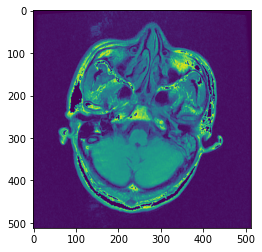

In [202]:
def read_label(src):
    # label = nib.load(src)
    dicom = pydicom.dcmread("././ser003img00006.dcm")
    # dicom.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
    dicom_arr = dicom.pixel_array
    # print(dicom_arr.dtype, np.unique(dicom_arr))
    dicom_arr[dicom_arr > 500] = 0
    # print(np.unique(dicom_arr))

    dicom.PixelData = dicom_arr.tobytes()
    dicom.save_as("./test.aaa.dcm")

    # print(label.dataobj.shape, label.dataobj.dtype)
    plt.imshow(dicom_arr)
    # img = np.transpose(label.dataobj[:, :, 29], (1, 0))
    # plt.imshow(img)
read_label("./10093643-T1c.nii")

In [73]:
def unzip_label():
    label_dir = "J:\\Dataset\\new\\row_label"
    output = "J:\Dataset\\new\label"
    labels = os.listdir(label_dir)
    for label in labels:
        file = os.path.join(label_dir, label)
        f_name = os.path.join(output, label.split('.')[0] + ".nii")
        g_file = gzip.GzipFile(file)
        open(f_name, "wb+").write(g_file.read())

unzip_label()

In [14]:
# 合并dicom  生成.npy文件
def merge_dicom():
    dicom_dir = "J:\\Dataset\\new\\raw_dicom"
    dicom_ids = np.array(os.listdir(dicom_dir))
    arc = "J:\Dataset\\new\out_dicom_match"
    label_dir = "J:\\Dataset\\new\\label_match"
    input_out = "J:\Dataset\\new\\test_image"
    mask_out = "J:\Dataset\\new\\test_label"

    for dicom_id in dicom_ids:
        if dicom_id in unmatch:
            continue
        os.mkdir(os.path.join(arc, dicom_id))
        os.mkdir(os.path.join(arc, dicom_id, "T1"))
        os.mkdir(os.path.join(arc, dicom_id, "T2"))
        os.mkdir(os.path.join(arc, dicom_id, "T1C"))
        # t1_files = os.listdir(os.path.join(dicom_dir, dicom_id) + "/T1/")
        # t2_files = os.listdir(os.path.join(dicom_dir, dicom_id) + "/T2/")
        # t1c_files = os.listdir(os.path.join(dicom_dir, dicom_id) + "/T1C/")
        # t1_files.sort(key= lambda x: x.split('.')[0][-2:], reverse=True)
        # t2_files.sort(key= lambda x: x.split('.')[0][-2:], reverse=True)
        # t1c_files.sort(key= lambda x: x.split('.')[0][-2:], reverse=True)
        # label = nib.load(os.path.join(label_dir, dicom_id + ".nii")).dataobj
        # # if label.shape[2] != len(t1c_files):
        # #     print(dicom_id, label.shape[2], len(t1c_files))
        # for i in range(len(t1c_files)):
        #     t1 = pydicom.dcmread(os.path.join(dicom_dir, dicom_id, "T1", t1_files[i]), force=True)
        #     t1.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
        #     t2 = pydicom.dcmread(os.path.join(dicom_dir, dicom_id, "T2", t2_files[i]), force=True)
        #     t2.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
        #     t1c = pydicom.dcmread(os.path.join(dicom_dir, dicom_id, "T1C", t1c_files[i]), force=True)
        #     t1c.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
        #
        #     t1 = t1.pixel_array
        #     t1 = torch.from_numpy(t1.astype(np.float32)).unsqueeze(dim=0).unsqueeze(dim=0)
        #     t2 = t2.pixel_array
        #     t2 = torch.from_numpy(t2.astype(np.float32)).unsqueeze(dim=0).unsqueeze(dim=0)
        #     t1c = t1c.pixel_array
        #     t1c = torch.from_numpy(t1c.astype(np.float32)).unsqueeze(dim=0).unsqueeze(dim=0)
        #     shape = label.shape[:2]
        #     if not (t1.shape == shape):
        #         t1 = F.interpolate(t1, mode='bilinear', size=shape, align_corners=True)
        #     if not (t2.shape == shape):
        #         t2 = F.interpolate(t2, mode='bilinear', size=shape, align_corners=True)
        #     if not (t1c.shape == shape):
        #         t1c = F.interpolate(t1c, mode='bilinear', size=shape, align_corners=True)
        #     input = torch.cat([t1, t2, t1c], dim=1).squeeze().permute(1, 2, 0).numpy()
        #     mask = label[:, :, i].transpose((1, 0)).astype(np.uint8)
        #     np.save(os.path.join(input_out, str(dicom_id) + "_" + str(i) + ".npy"), input)
        #     np.save(os.path.join(mask_out, str(dicom_id) + "_" + str(i) + ".npy"), mask)
merge_dicom()

In [11]:
# 计算有标注的文件的平均dice
def average():
    dicom_dir = "J:\Dataset\\new\out_dicom"

    dicom_ids = np.array(os.listdir(dicom_dir))
    count = 0
    dice = 0.0
    for dicom_id in dicom_ids:
        images = os.listdir(os.path.join(dicom_dir, dicom_id, "T1C"))
        for image in images:
            score = image.split("_")[1][:-4]
            # print(image)
            if float(score) > 0:
                dice += float(score)
                count += 1
    print(dice, count)
    ave_dice = dice / count
    print(ave_dice)
    return ave_dice

dice = average()

1381.705967886722 1992
0.6936274939190371
